# Matched VE Analysis: Updated Pipeline with Z-Scored Outcome Measures

In [385]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import copy

### If pipeline has already been run through once, load in data to save time

In [466]:
_dir = '/Users/pmahableshwarkar/Documents/Depth_Project/verbal_judgement_analysis'
raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalVEMatched/z_scored/'

final_data = pd.read_csv (raw_dir + '/raw_data.csv')
zscored_data = pd.read_csv (zs_dir + '/z_scored_data.csv')

In [386]:
num_trials = 156

In [387]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 

    exclude: list of subject IDs that should be excluded from the final df 

    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
#         if age > 1900:
#             actual_age = 2022-age
#             # update age in existing dataframe
#             input_data.at[idx, 'age'] = actual_age

    return input_data    

def catchTrial_cleaning(path, correct_requirement, catch_stimuli, sequence_count):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 6/8 catch trials are correct, the participant is excluded.  
    '''
    
    df = cleanAgeResponses(path)
    
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    
    for subj in all_subjIDs:
#         print(subj)
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        count_correct = 0
        for idx, row in subj_df.iterrows():
            stim = row['stimulus']
            if type(stim) == str:
                if stim.split('/')[1] in catch_stimuli:
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE HAS NO TARGET
#                     print(row['depth_estimate'])
#                     print(row['stimulus'])
                    if row["depth_estimate"] == 0:
                        count_correct += 1

                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)

        if count_correct < correct_requirement:
            remove.append(subj)
        else:
            sequence_count[subj_df.sequenceName.unique()[0]] += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)

#     for index, row in df2.iterrows():
#         if row['subjID'] in remove:
#             df2.drop(index, inplace=True)
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
    
    return df2
    

def removeMissedTrials(input_data, num_trials):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
#     input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        # do catch trial check FIRST
        # then have the missing trial function 
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(num_trials * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

#     for index, row in input_data.iterrows():
#         if row['subjID'] in remove_ids:
#             input_data.drop(index, inplace=True)
            
    for subj in remove_ids:
        input_data.drop(input_data[input_data['subjID'] == subj].index, inplace = True) 

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [388]:
path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data'


In [389]:
sequences_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/jsons'
sequences_count_dict = {}
for seq in os.listdir(sequences_path):
    if 'json' in seq:
        sequences_count_dict['jsons/'+seq] = 0


In [390]:

all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [391]:
catch_trial_cleaned_data = catchTrial_cleaning(path, 6, all_catch_stim, sequences_count_dict)

Number of participants before cleaning:  1100
Number of participants that did not pass the catch trial check: 358
Participants that were removed: [993293, 337855, 361118, 384084, 672587, 199719, 213165, 810569, 552070, 271282, 454653, 235866, 756315, 204178, 623759, 626250, 121796, 360771, 358793, 145368, 980305, 252260, 970492, 250584, 634447, 465507, 602927, 593754, 329190, 245150, 653026, 621633, 829661, 988435, 779298, 477725, 698532, 564687, 735548, 388835, 297316, 926551, 686124, 705460, 158127, 158205, 786056, 729944, 662848, 837088, 287484, 219796, 445032, 739896, 531988, 413923, 991770, 218701, 644462, 663587, 180648, 838264, 603293, 651729, 506066, 905663, 118627, 603376, 492147, 469479, 272047, 647678, 952653, 757584, 870425, 113882, 379933, 141370, 711133, 165253, 255119, 737436, 336867, 970981, 577956, 529889, 713343, 910393, 925395, 666910, 128865, 579336, 676615, 191373, 866086, 603735, 502526, 599477, 622232, 908721, 663932, 724385, 512637, 203565, 415111, 354578, 93992

In [392]:
missed_trial_cleaned_data = removeMissedTrials(catch_trial_cleaned_data, num_trials)

Number of participants with 10% or more missed trials:  97


#### Distribution of Unit Preferences

In [8]:
pre_unitconversion_data = combineCSVs(path)

In [9]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit[0] == "feet":
        feet_count += 1
    if unit[0] == "meters":
        meters_count += 1
    
meters_count, feet_count

### In this version, the RT exclusion criterion is the same for all participants [1000 ms, 10000 ms]


In [393]:
def RT_Cleaning(df, outlier_range, num_trials):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
#     for index, row in df2.iterrows():
#         if row['subjID'] in remove:
#             df2.drop(index, inplace=True)
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
                
    return df2

In [394]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data, [250, 10000], num_trials)

Number of Participants with 10% or more trials outside their RT range:  75


In [395]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
#     for index, row in df.iterrows():
#         if row['subjID'] in remove:
#             df.drop(index, inplace=True)
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 

    
    return df, max_repeats_distribution, num_unique_responses_distribution



In [396]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(RT_cleaned_data)

Number of participants removed: repeat responses:  84


In [397]:
# repeat_resp_cleaned_data

In [398]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
#     for index, row in df.iterrows():
#         if row['subjID'] in remove:
#             df.drop(index, inplace=True)
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [399]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data, num_trials)

Number of Participants with >= 10% trials removed:  22
Number of participants left:  464


In [401]:
len(cleaned_data.sequenceName.unique())

460

# of subjs with 156 trials:  78
Average # of trials:  151


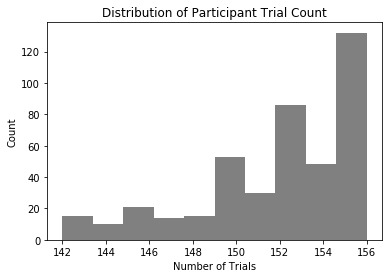

In [32]:
# subselect subjects that have 156 trials (none removed in outlier cleaning)

completeData_subjects = []
cD_distribution = []
all_subjIDs = cleaned_data.subjID.unique()
    
for subj in all_subjIDs:
    subj_df = cleaned_data.loc[cleaned_data['subjID'] == subj]
    count_trials = len(subj_df.index)
    cD_distribution.append(count_trials)
    if count_trials == 156:
        completeData_subjects.append(subj)

print('# of subjs with 156 trials: ',len(completeData_subjects))
print('Average # of trials: ', int(np.mean(cD_distribution)))

plt.hist(cD_distribution, color='gray')
# plt.xticks(np.arange(174, 194, 2))
plt.title('Distribution of Participant Trial Count')
plt.xlabel('Number of Trials')
plt.ylabel('Count')
plt.show()

v1_VE1000_randls_2_rotated.json
['148431', '526603']
2
VE125_randls_73.json
['577833', '851484']
2
v1_VE1000_randls_51_rotated.json
['939017', '596417']
2
v1_VE1000_randls_49.json
['188600', '210230']
2

In [402]:
# remove participants where there are duplicates in sequence sampling 
# keep the data from the participant that submitted first 
remove = [526603, 851484, 596417, 210230]
for index, row in cleaned_data.iterrows():
    if row['subjID'] in remove:
        cleaned_data.drop(index, inplace=True)

In [406]:
final_data = cleaned_data.copy(deep=True)

In [407]:
len(final_data.subjID.unique())

460

399605
399605 1000 44.979166666666664
609937
609937 125 58.42176870748299
163803
163803 125 45.214765100671144
832487
832487 125 42.567567567567565
845928
845928 125 54.92857142857143
844864
844864 1000 64.54248366013071


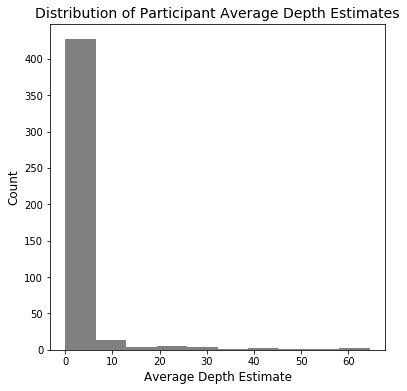

In [415]:
avgs = []
for subj in cleaned_data.subjID.unique():
    subj_df = final_data.loc[final_data['subjID'] == subj]
    subj_avg = np.mean(np.array(subj_df['depth_estimate']))
    avgs.append(subj_avg)
    if subj_avg > 40:
        print(subj)
        print(subj, subj_df.duration.unique()[0], subj_avg)
#     if subj_avg < 25:  
#         avgs.append(subj_avg)
    
plt.figure(figsize=[6,6])    
plt.hist(avgs, color='gray')
# plt.xticks(np.arange(174, 194, 2))
plt.title('Distribution of Participant Average Depth Estimates', fontsize=14)
plt.xlabel('Average Depth Estimate', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Z-Score Depth Estimates and RT 

In [416]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score depth estimates
        average_estim = subj_df["depth_estimate"].mean()
        std_estim = subj_df["depth_estimate"].std()
        subj_depth_estimates = np.array(list(subj_df["depth_estimate"]))
        zscored_subj_depth_estimates = (subj_depth_estimates - average_estim)/std_estim
        final_subj_df.replace(subj_depth_estimates, zscored_subj_depth_estimates, inplace=True)
        # Z-Score RT
        average_RT = subj_df["trial_RT"].mean()
        std_RT = subj_df["trial_RT"].std()
        subj_RTs = np.array(list(subj_df["trial_RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.replace(subj_RTs, zscored_subj_RTs, inplace=True)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [417]:
zscored_data = zscored_outcomes(final_data)

In [418]:
average_depth_estimate = final_data['depth_estimate'].mean()
average_depth_estimate

3.6239578726099095

#### Unit Distribution 

In [16]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

#### Age

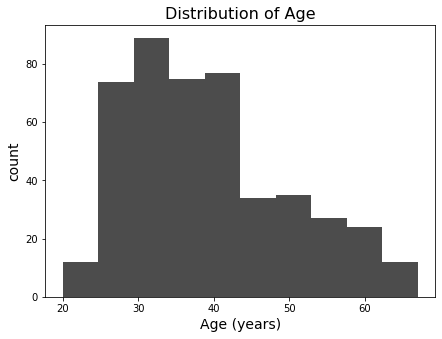

In [419]:
cleaned_ages = []
for subj in final_data.subjID.unique():
    subj_df = final_data.loc[final_data['subjID'] == subj]
    subj_age = subj_df.age.unique()[0]
    
    if subj_age > 1900:
        cleaned_ages.append(2022-subj_age)
    else:
        if subj_age > 18:
            cleaned_ages.append(subj_age)
            
plt.figure(figsize = [7,5])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Distribution of Age', fontsize=16)

plt.hist(cleaned_ages, color='black', alpha=0.7)
plt.show()


In [420]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


In [421]:
def AnovaRM_subjectData(df, durations):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        for duration in durations:
            duration_subj_df = subj_df
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df


In [422]:
zs_final_data_125 = zscored_data.loc[zscored_data["duration"]  == 125]
zs_final_data_250 = zscored_data.loc[zscored_data["duration"]  == 250]
zs_final_data_1000 = zscored_data.loc[zscored_data["duration"]  == 1000]

In [423]:
final_data_125 = final_data.loc[final_data["duration"]  == 125]
final_data_250 = final_data.loc[final_data["duration"]  == 250]
final_data_1000 = final_data.loc[final_data["duration"]  == 1000]

In [424]:
slopes_125, df_intercept_125 = AnovaRM_subjectData(zs_final_data_125, [125])
slopes_250, df_intercept_250 = AnovaRM_subjectData(zs_final_data_250, [250])
slopes_1000, df_intercept_1000 = AnovaRM_subjectData(zs_final_data_1000, [1000])

In [425]:
raw_slopes_125, raw_df_intercept_125 = AnovaRM_subjectData(final_data_125, [125])
raw_slopes_250, raw_df_intercept_250 = AnovaRM_subjectData(final_data_250, [250])
raw_slopes_1000, raw_df_intercept_1000 = AnovaRM_subjectData(final_data_1000, [1000])

### Z-scored Data split by duration

In [426]:
z_data_125ms = zscored_data[zscored_data['duration'] == 125]
z_data_250ms = zscored_data[zscored_data['duration'] == 250]
z_data_1000ms = zscored_data[zscored_data['duration'] == 1000]

zscored_duration_data = [z_data_125ms, z_data_250ms, z_data_1000ms]


In [494]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'
durations = ['125', '250', '1000']

for i in range(len(duration_data)):  
    zscored_duration_data[i].to_csv(dest + 'z_scored_' + durations[i] + '_data.csv' , index=True)

zscored_data.to_csv(dest + 'z_scored' + '_data.csv' , index=True)

# Individual Target Results


In [495]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 125
        if cond == 1:
            result["Duration"] = 250
        if cond == 2:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [496]:
zscored_trial_pivot = trial_pivotTable(zscored_duration_data)


In [497]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [125, 250, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_125, x_250, x_1000]
        xs = [list of individual targets]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)

    return xs, ys, stes, actualdepths, stds, trial_RTs

In [498]:
trial_zscored_final = trial_getxy(zscored_trial_pivot)


### Z-scored Data

In [499]:
z_trial_plot_data = trial_zscored_final

## Execute this cell to prep for plotting

z_final_x_125 = z_trial_plot_data[0][0]
z_final_y_125 = z_trial_plot_data[1][0]
z_ste_125 = z_trial_plot_data[2][0]
z_stim_125 = z_trial_plot_data[3][0]
z_std_125 = z_trial_plot_data[4][0]
z_RT_125 = z_trial_plot_data[5][0]

z_final_x_250 = z_trial_plot_data[0][1]
z_final_y_250 = z_trial_plot_data[1][1]
z_ste_250 = z_trial_plot_data[2][1]
z_stim_250 = z_trial_plot_data[3][1]
z_std_250 = z_trial_plot_data[4][1]
z_RT_250 = z_trial_plot_data[5][1]

z_final_x_1000 = z_trial_plot_data[0][2]
z_final_y_1000 = z_trial_plot_data[1][2]
z_ste_1000 = z_trial_plot_data[2][2]
z_stim_1000 = z_trial_plot_data[3][2]
z_std_1000 = z_trial_plot_data[4][2]
z_RT_1000 = z_trial_plot_data[5][2]

#### Correlation between depth estimates in each duration

In [500]:
scipy.stats.pearsonr(z_final_y_125, z_final_y_250)

(0.9819166291612074, 3.172370807796425e-113)

In [501]:
scipy.stats.pearsonr(z_final_y_125, z_final_y_1000)

(0.9743459614950767, 1.1781373733573999e-101)

In [502]:
scipy.stats.pearsonr(z_final_y_250, z_final_y_1000)

(0.9882585439060464, 1.4572645584460125e-127)

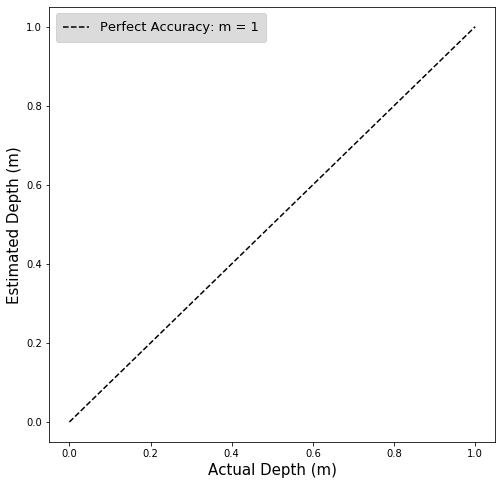

In [436]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])

plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)

X = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.plot(X, X, label = "Perfect Accuracy: m = 1", color = 'black',linestyle='--')  # solid

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



In [595]:
pi = 55
z_final_x_125[pi], z_final_y_125[pi]

('depth_duration_stimuli/002340_2014-06-28_20-05-46_260595134347_rgbf000113-resize_0/002340_2014-06-28_20-05-46_260595134347_rgbf000113-resize_0-target.png',
 0.5597464716304568)

In [596]:
pj = z_final_x_250.index(z_final_x_125[pi])

z_final_x_250[pj]

'depth_duration_stimuli/002340_2014-06-28_20-05-46_260595134347_rgbf000113-resize_0/002340_2014-06-28_20-05-46_260595134347_rgbf000113-resize_0-target.png'

m: [0.48994636]
b: -1.4977503543452266
R-squared:  0.6791369551360832


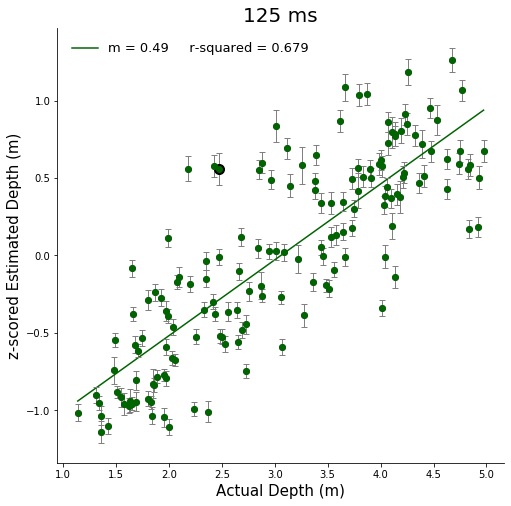

In [597]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_stim_125).reshape(-1,1)
y = z_final_y_125
ste = z_ste_125
std = z_std_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth (m)", fontsize = 15)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)


plt.plot(z_stim_125[pi], z_final_y_125[pi], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black", alpha=1)


plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_125 = copy.deepcopy(y - y_predicted)


m: [0.53130639]
b: -1.6245722022011497
R-squared:  0.7365673145882156


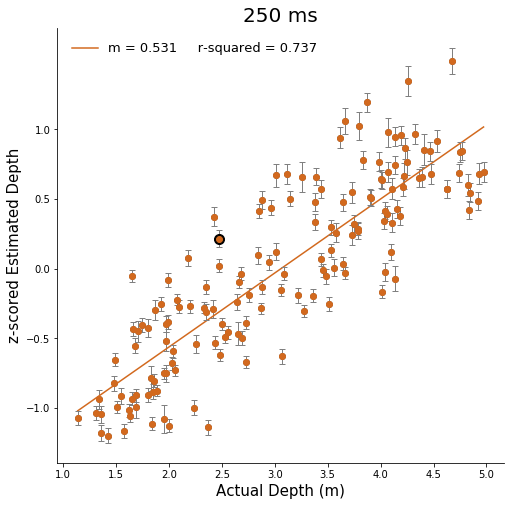

In [598]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_stim_250).reshape(-1,1)
y = z_final_y_250
ste = z_ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth", fontsize = 15)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

plt.plot(z_stim_250[pj], z_final_y_250[pj], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black", alpha=1)

plt.yticks(np.arange(-1,1.5, 0.5))


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_250 = copy.deepcopy(y - y_predicted)


m: [0.5477647]
b: -1.6745970810529616
R-squared:  0.7369018040321365


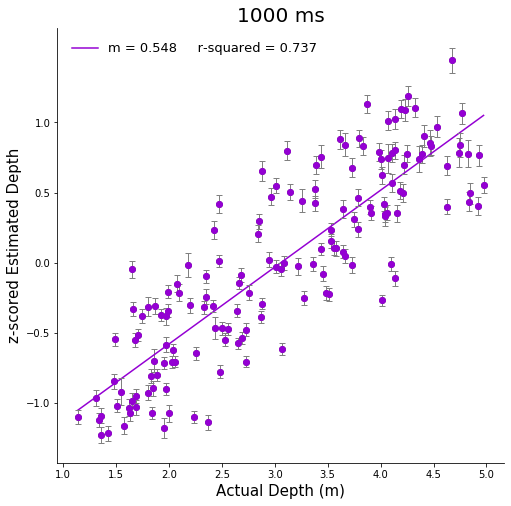

In [551]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_stim_1000).reshape(-1,1)
y = z_final_y_1000
ste = z_ste_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth", fontsize = 15)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.yticks(np.arange(-1,1.5, 0.5))


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_1000 = copy.deepcopy(y - y_predicted)


In [553]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/residuals/'

with open(destpath + 'z_residuals_125.npy', 'wb') as f:
    np.save(f, residuals_125)
with open(destpath + 'z_residuals_250.npy', 'wb') as f:
    np.save(f, residuals_250)
with open(destpath + 'z_residuals_1000.npy', 'wb') as f:
    np.save(f, residuals_1000)

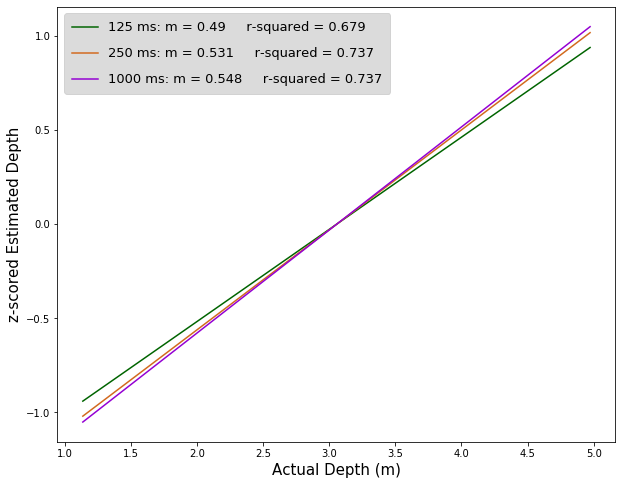

In [552]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [10,8])

#run regression
z_X_125 = np.array(z_stim_125).reshape(-1,1)
z_y_125 = z_final_y_125
z_ste_125 = z_ste_125
z_reg_125 = LinearRegression().fit(z_X_125, z_y_125)

#Generated Predictions
z_y_predicted_125 = z_reg_125.predict(z_X_125)
#Plot Our Actual and Predicted Values
plt.plot(z_X_125,z_y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(z_reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_125.score(z_X_125, z_y_125)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth", fontsize = 15)
# plt.errorbar(X_125, y_125, yerr=ste_125, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

#run regression
z_X_250 = np.array(z_stim_250).reshape(-1,1)
z_y_250 = z_final_y_250
z_ste_250 = z_ste_250
z_reg_250 = LinearRegression().fit(z_X_250, z_y_250)

#Generated Predictions
z_y_predicted_250 = z_reg_250.predict(z_X_250)
#Plot Our Actual and Predicted Values
plt.plot(z_X_250,z_y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(z_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_250.score(z_X_250, z_y_250)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth", fontsize = 15)
# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)


#run regression
z_X_1000 = np.array(z_stim_1000).reshape(-1,1)
z_y_1000 = z_final_y_1000
z_ste_1000 = z_ste_1000
z_reg_1000 = LinearRegression().fit(z_X_1000, z_y_1000)

#Generated Predictions
z_y_predicted_1000 = z_reg_1000.predict(z_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(z_X_1000,z_y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(z_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_1000.score(z_X_1000, z_y_1000)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth", fontsize = 15)
# plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



In [441]:
zs_avg_slope_125 = np.mean(np.array(slopes_125['slope']))
zs_ste_slope_125 = stats.sem(np.array(slopes_125['slope']))

zs_avg_slope_250 = np.mean(np.array(slopes_250['slope']))
zs_ste_slope_250 = stats.sem(np.array(slopes_250['slope']))

zs_avg_slope_1000 = np.mean(np.array(slopes_1000['slope']))
zs_ste_slope_1000 = stats.sem(np.array(slopes_1000['slope']))

In [627]:
len(slopes_125['slope']) + len(slopes_250['slope']) + len(slopes_1000['slope'])

460

In [561]:
slopes_0 = [0] * len(slopes_250)


In [609]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_250['slope'], slopes_1000['slope'], slopes_0)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_0)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_0, slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_250['slope'], slopes_0)
print(fvalue, pvalue)

266.1471965998601 2.8165665824236446e-110
918.8712686841537 1.3083197609230047e-93
780.9335473389466 3.2084000685765386e-86
721.9243666957688 4.6501648621952667e-82


In [611]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_250['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_250['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_250['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

2.4693578270198673 0.08576792005005972
2.4407932861533252 0.11926368448065941
5.0125468562078 0.025882843824093726
0.3651040010478538 0.5461328990291895


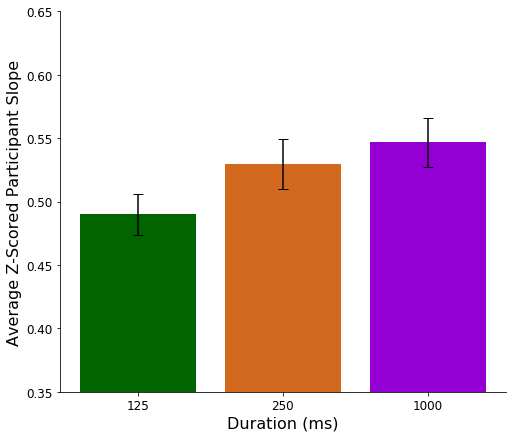

In [442]:
# creating the dataset
durations = ['125', '250', '1000']

zs_slopes = [zs_avg_slope_125, zs_avg_slope_250, zs_avg_slope_1000]
zs_slopes_sem = [zs_ste_slope_125, zs_ste_slope_250, zs_ste_slope_1000]

fig, ax = plt.subplots(figsize=[8,7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(0.35, 0.6)
plt.yticks(np.arange(0.35, 0.65, 0.05),fontsize=12)

# creating the bar plot
plt.bar(durations, zs_slopes, yerr = zs_slopes_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Z-Scored Participant Slope", fontsize=16)

plt.show()

m: [1.02245353]
b: -0.00032252415182852916
R-squared:  0.9641602666233082


0.964

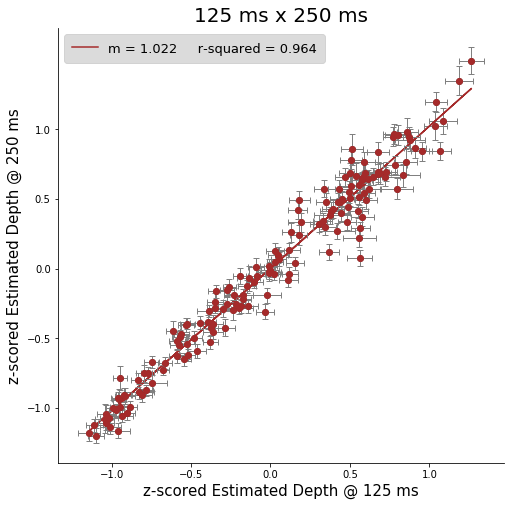

In [443]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_125).reshape(-1,1)
y = z_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 250 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)


plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

m: [1.04576129]
b: -2.4433891936722534e-05
R-squared:  0.9493500526817656


0.949

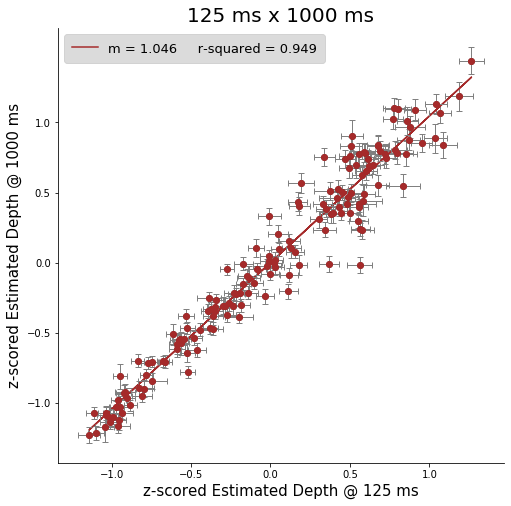

In [444]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_125).reshape(-1,1)
y = z_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 1000 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 1000 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)

plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

m: [1.01864061]
b: 0.00030842436418796436
R-squared:  0.9766549496032993


0.977

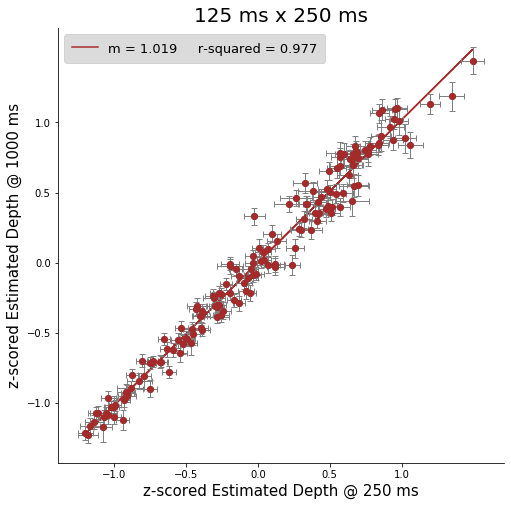

In [445]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_250).reshape(-1,1)
y = z_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 250 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 1000 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)

plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

## Model Residuals

m: [0.89130101]
b: -1.274522279491325e-16
R-squared:  0.8924027654089037


0.892

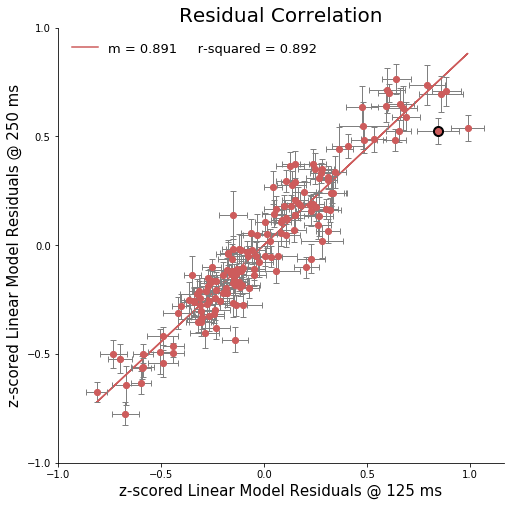

In [599]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#run regression
X = np.array(z_residuals_125).reshape(-1,1)
y = z_residuals_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='indianred', alpha = 0.5);
plt.plot(X,y_predicted,color='indianred', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))

plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "indianred", mec = "indianred", capsize = 3)


plt.plot(z_residuals_125[pi], z_residuals_250[pi], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black", alpha=1)

plt.title("Residual Correlation", fontsize = 20)
plt.xlabel("z-scored Linear Model Residuals @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Linear Model Residuals @ 250 ms", fontsize = 15)

plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

In [296]:
# from string import ascii_letters
# import seaborn as sns

# data = {'125': z_residuals_125,
#         '250': z_residuals_250,
#         '1000': z_residuals_1000
#         }


# df = pd.DataFrame(data,columns=['125','250','1000'])

# plt.figure(figsize = [12, 8])
# plt.title("Residual Correlations by Duration", fontsize = 20)
# df_corr = df.corr()
# ax = sns.heatmap(df_corr, annot=True) 
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

### Analysis of STD by scene and duration

In [613]:
scipy.stats.pearsonr(z_std_125, z_std_250)

(0.4592384955435378, 1.6396138935802898e-09)

In [614]:
scipy.stats.pearsonr(z_std_125, z_std_1000)

(0.43407403620446067, 1.5036447564297184e-08)

In [615]:
scipy.stats.pearsonr(z_std_250, z_std_1000)

(0.503698598593117, 2.0476206206823194e-11)

m: [0.07291012]
b: 0.535709619352188
R-squared:  0.18093086440227035
(0.42535968826661325, 3.1088079555746154e-08)


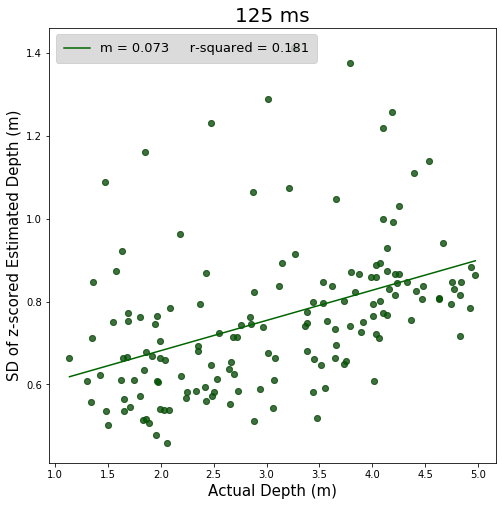

In [612]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(z_stim_125).reshape(-1,1)
y = z_std_125


reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("SD of z-scored Estimated Depth (m)", fontsize = 15)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3, alpha=0.5)

legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

print(scipy.stats.pearsonr(z_stim_125, y))

m: [0.08027372]
b: 0.4900521530714404
R-squared:  0.21019335317940024
(0.4584684865717603, 1.759395133462697e-09)


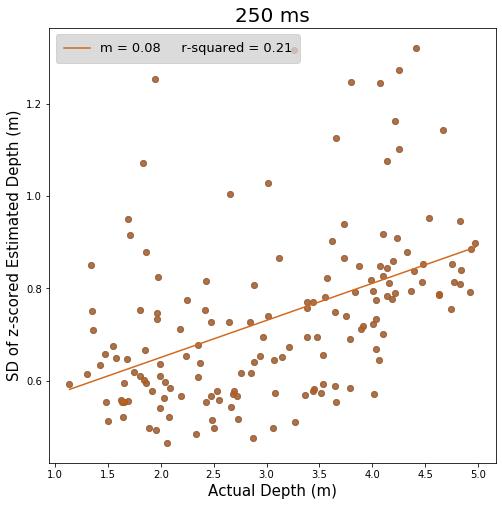

In [451]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(z_stim_250).reshape(-1,1)
y = z_std_250


reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("SD of z-scored Estimated Depth (m)", fontsize = 15)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3, alpha=0.5)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

print(scipy.stats.pearsonr(z_stim_250, y))

m: [0.06943749]
b: 0.5089186591700473
R-squared:  0.18936947617413624
(0.43516603288186034, 1.3708352340104538e-08)


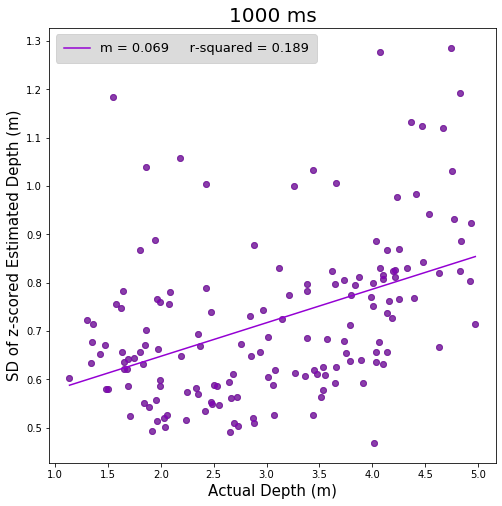

In [452]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(z_stim_1000).reshape(-1,1)
y = z_std_1000


reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("SD of z-scored Estimated Depth (m)", fontsize = 15)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3, alpha=0.5)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

print(scipy.stats.pearsonr(z_stim_1000, y))

In [616]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(z_ste_125, z_ste_250, z_ste_1000)
print(fvalue, pvalue)

3.0806391018859274 0.04686855559235552


In [628]:
def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 

def subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes_intercepts = {'subjID': [], 'duration': [], 'slope': [], 'intercept' : [], 'age': [], 'gender': []}
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        subj_pivot = subject_pivotTable(subj_df, subj_df.duration.unique()[0])
        subj_data = subject_getxy(subj_pivot)
        x = np.array(subj_data[0])
        y = np.array(subj_data[1])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        subj_slopes_intercepts['subjID'].append(subj)
        subj_slopes_intercepts['duration'].append(subj_df.duration.unique()[0])
        subj_slopes_intercepts['slope'].append(slope)
        subj_slopes_intercepts['intercept'].append(intercept)
        subj_slopes_intercepts['age'].append(subj_df.age.unique()[0])
        subj_slopes_intercepts['gender'].append(subj_df.gender.unique()[0])
        


    df = pd.DataFrame(data=subj_slopes_intercepts)
        
    return df  


In [629]:
subject_summary = subjectData(zscored_data)


In [503]:
dp = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'
subject_summary.to_csv(dp + 'z_scored_subjSummary.csv') 

In [457]:
zs_subject_summary_125 = subject_summary.loc[subject_summary["duration"]  == 125]
zs_subject_summary_250 = subject_summary.loc[subject_summary["duration"]  == 250]
zs_subject_summary_1000 = subject_summary.loc[subject_summary["duration"]  == 1000]

https://www.reneshbedre.com/blog/anova.html

In [458]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(zs_subject_summary_125['slope'], zs_subject_summary_250['slope'], zs_subject_summary_1000['slope'])
print(fvalue, pvalue)

2.4693578270198673 0.08576792005005972


In [459]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(zs_subject_summary_125['slope'], zs_subject_summary_250['slope'])
print(fvalue, pvalue)


2.4407932861533252 0.11926368448065941


In [462]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(zs_subject_summary_125['slope'], zs_subject_summary_1000['slope'])
print(fvalue, pvalue)

5.0125468562078 0.025882843824093726


In [467]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(zs_subject_summary_250['slope'], zs_subject_summary_1000['slope'])
print(fvalue, pvalue)

0.3651040010478538 0.5461328990291895


In [504]:
n_destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# 125 ms
with open(n_destpath + 'X_125.npy', 'wb') as f:
    
    np.save(f, z_stim_125)
with open(n_destpath + 'z_final_y_125.npy', 'wb') as f:
    np.save(f, z_final_y_125)
with open(n_destpath + 'z_std_125.npy', 'wb') as f:
    np.save(f, z_std_125)
with open(n_destpath + 'z_ste_125.npy', 'wb') as f:
    np.save(f, z_ste_125)
with open(n_destpath + 'z_final_stim_125.npy', 'wb') as f:
    np.save(f, z_final_x_125)
    
# 250 ms    
with open(n_destpath + 'X_250.npy', 'wb') as f:
    np.save(f, z_stim_250)
with open(n_destpath + 'z_final_y_250.npy', 'wb') as f:
    np.save(f, z_final_y_250)
with open(n_destpath + 'z_std_250.npy', 'wb') as f:
    np.save(f, z_std_250)
with open(n_destpath + 'z_ste_250.npy', 'wb') as f:
    np.save(f, z_ste_250)
with open(n_destpath + 'z_final_stim_250.npy', 'wb') as f:
    np.save(f, z_final_x_250)
    
# 1000 ms
with open(n_destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, z_stim_1000)
with open(n_destpath + 'z_final_y_1000.npy', 'wb') as f:
    np.save(f, z_final_y_1000)
with open(n_destpath + 'z_std_1000.npy', 'wb') as f:
    np.save(f, z_std_1000)
with open(n_destpath + 'z_ste_1000.npy', 'wb') as f:
    np.save(f, z_ste_1000)    
with open(n_destpath + 'z_final_stim_1000.npy', 'wb') as f:
    np.save(f, z_final_x_1000)

### Raw Data 

In [630]:
duration_data = [final_data[final_data['duration'] == 125], final_data[final_data['duration'] == 250], final_data[final_data['duration'] == 1000]]


In [631]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'
durations = ['125', '250', '1000']

for i in range(len(duration_data)):  
    duration_data[i].to_csv(dest + 'raw' + durations[i] + '_data.csv' , index=True)

final_data.to_csv(dest + 'raw' +  '_data.csv' , index=True)

In [632]:
raw_trial_pivot = trial_pivotTable(duration_data)


In [633]:
# raw_trial_pivot[0]

In [634]:
trial_raw_final = trial_getxy(raw_trial_pivot)


In [635]:
# trial_raw_final


### Raw Data

In [636]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting

final_x_125 = trial_plot_data[0][0]
final_y_125 = trial_plot_data[1][0]
ste_125 = trial_plot_data[2][0]
stim_125 = trial_plot_data[3][0]
std_125 = trial_plot_data[4][0]
RT_125 = trial_plot_data[5][0]

final_x_250 = trial_plot_data[0][1]
final_y_250 = trial_plot_data[1][1]
ste_250 = trial_plot_data[2][1]
stim_250 = trial_plot_data[3][1]
std_250 = trial_plot_data[4][1]
RT_250 = trial_plot_data[5][1]

final_x_1000 = trial_plot_data[0][2]
final_y_1000 = trial_plot_data[1][2]
ste_1000 = trial_plot_data[2][2]
stim_1000 = trial_plot_data[3][2]
std_1000 = trial_plot_data[4][2]
RT_1000 = trial_plot_data[5][2]

In [637]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'

# 125 ms
with open(destpath + 'X_125.npy', 'wb') as f:
    np.save(f, stim_125)
with open(destpath + 'final_y_125.npy', 'wb') as f:
    np.save(f, final_y_125)
with open(destpath + 'std_125.npy', 'wb') as f:
    np.save(f, std_125)
with open(destpath + 'ste_125.npy', 'wb') as f:
    np.save(f, ste_125)
with open(destpath + 'final_stim_125.npy', 'wb') as f:
    np.save(f, final_x_125)
    
# 250 ms    
with open(destpath + 'X_250.npy', 'wb') as f:
    np.save(f, stim_250)
with open(destpath + 'final_y_250.npy', 'wb') as f:
    np.save(f, final_y_250)
with open(destpath + 'std_250.npy', 'wb') as f:
    np.save(f, std_250)
with open(destpath + 'ste_250.npy', 'wb') as f:
    np.save(f, ste_250)
with open(destpath + 'final_stim_250.npy', 'wb') as f:
    np.save(f, final_x_250)
    
# 1000 ms
with open(destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, stim_1000)
with open(destpath + 'final_y_1000.npy', 'wb') as f:
    np.save(f, final_y_1000)
with open(destpath + 'std_1000.npy', 'wb') as f:
    np.save(f, std_1000)
with open(destpath + 'ste_1000.npy', 'wb') as f:
    np.save(f, ste_1000)    
with open(destpath + 'final_stim_1000.npy', 'wb') as f:
    np.save(f, final_x_1000)

#### Correlation between raw depth estimates at each duration

In [638]:
scipy.stats.pearsonr(final_y_125, final_y_250)

(0.8194541752038835, 4.6269893270305867e-39)

In [639]:
scipy.stats.pearsonr(final_y_125, final_y_1000)

(0.8966100832655244, 2.3622460538396747e-56)

In [640]:
scipy.stats.pearsonr(final_y_250, final_y_1000)

(0.8410734780321134, 6.082669894392951e-43)

m: [0.57598204]
b: 1.7188857711805856
R-squared:  0.6026465772655865


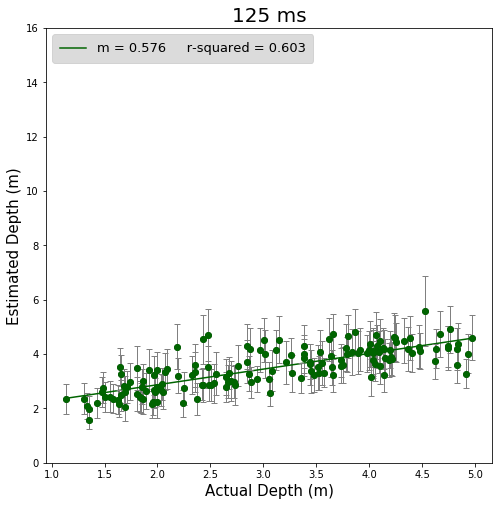

In [641]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(stim_125).reshape(-1,1)
y = final_y_125
ste = ste_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)


plt.ylim([0,16])

legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_125 = copy.deepcopy(y - y_predicted)

m: [0.67784514]
b: 1.291266553680619
R-squared:  0.6215573836783472


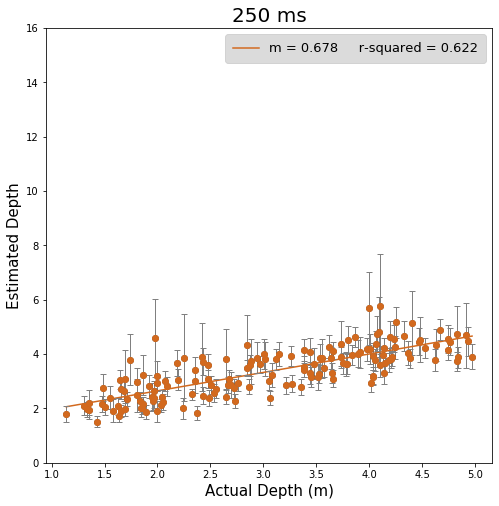

In [642]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
ste = ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)


plt.ylim([0,16])


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_250 = copy.deepcopy(y - y_predicted)

m: [0.76092798]
b: 1.6899349898749483
R-squared:  0.6686601337520989


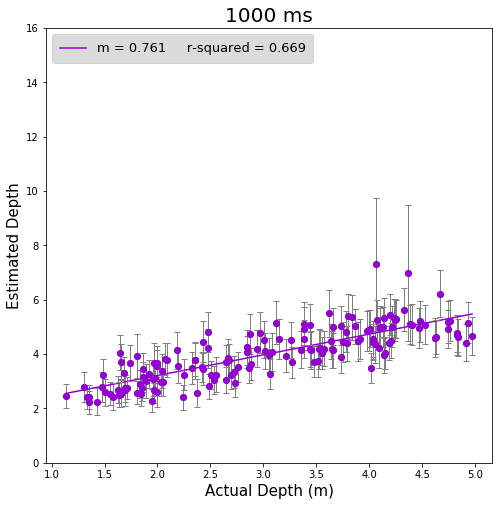

In [643]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
ste = ste_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.ylim([0,16])

legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_1000 = copy.deepcopy(y - y_predicted)

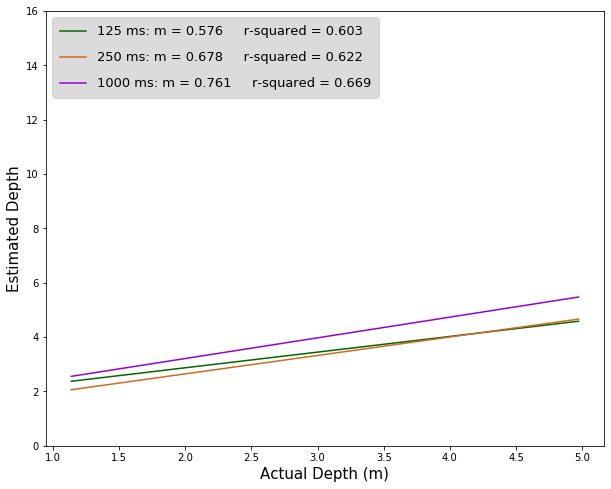

In [644]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [10,8])

#run regression
X_125 = np.array(stim_125).reshape(-1,1)
y_125 = final_y_125
ste_125 = ste_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125,y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)
# plt.errorbar(X_125, y_125, yerr=ste_125, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
ste_250 = ste_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)
# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)


#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
ste_1000 = ste_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)
# plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.ylim([0,16])

legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



In [645]:
raw_avg_slope_125 = np.mean(np.array(raw_slopes_125['slope']))
raw_ste_slope_125 = stats.sem(np.array(raw_slopes_125['slope']))

raw_avg_slope_250 = np.mean(np.array(raw_slopes_250['slope']))
raw_ste_slope_250 = stats.sem(np.array(raw_slopes_250['slope']))

raw_avg_slope_1000 = np.mean(np.array(raw_slopes_1000['slope']))
raw_ste_slope_1000 = stats.sem(np.array(raw_slopes_1000['slope']))

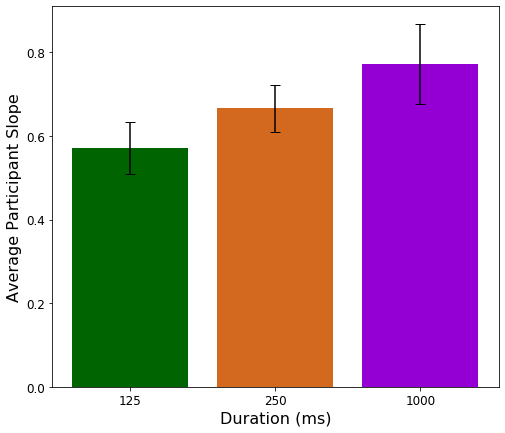

In [646]:
# creating the dataset
durations = ['125', '250', '1000']
# raw_slopes = [reg_125.coef_[0], reg_250.coef_[0], reg_1000.coef_[0]]
raw_slopes = [raw_avg_slope_125, raw_avg_slope_250, raw_avg_slope_1000]
raw_slopes_sem = [raw_ste_slope_125, raw_ste_slope_250, raw_ste_slope_1000]

fig = plt.figure(figsize = (8, 7))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# creating the bar plot
plt.bar(durations, raw_slopes, yerr = raw_slopes_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant Slope", fontsize=16)
# plt.title("Students enrolled in different courses")
plt.show()

m: [0.94959178]
b: 0.05944748098973385
R-squared:  0.6715051452590769


0.672

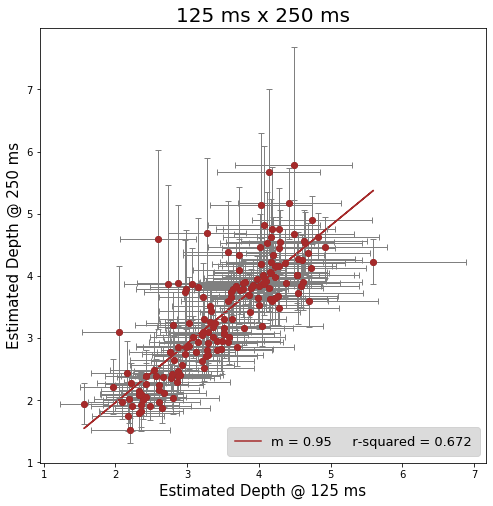

In [647]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X = np.array(final_y_125).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 250 ms", fontsize = 20)
plt.xlabel("Estimated Depth @ 125 ms", fontsize = 15)
plt.ylabel("Estimated Depth @ 250 ms", fontsize = 15)
plt.errorbar(X, y, xerr= ste_125, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

In [648]:
raw_subject_summary = subjectData(final_data)


In [507]:
dp = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'
raw_subject_summary.to_csv(dp + 'raw_subjSummary.csv') 

In [487]:
from pingouin import ancova, read_dataset

print("DV: Slope")
ancova(data=raw_subject_summary, dv='slope', covar='age', between='duration')

DV: Slope


,Source,SS,DF,F,p-unc,np2
0,duration,2.229451,2,1.196431,0.303299,0.005665
1,age,14.805612,1,15.890806,0.000079,0.036456
2,Residual,391.317909,420,NaN,NaN,NaN


https://www.reneshbedre.com/blog/anova.html

In [649]:
raw_subject_summary_125 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 125]
raw_subject_summary_250 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 250]
raw_subject_summary_1000 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 1000]

In [650]:
len(raw_subject_summary_125) + len(raw_subject_summary_250) + len(raw_subject_summary_1000)

460

In [651]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_250['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

1.8614806926372327 0.1566189766190972


In [652]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_250['slope'])
print(fvalue, pvalue)


1.2750922787143242 0.2597096836022871


In [653]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

3.083575685275344 0.08008688585349244


In [654]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(raw_subject_summary_250['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

0.8986743412785951 0.343885455742062


## Model Residuals

In [655]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/residuals/'

with open(destpath + 'residuals_125.npy', 'wb') as f:
    np.save(f, residuals_125)
with open(destpath + 'residuals_250.npy', 'wb') as f:
    np.save(f, residuals_250)
with open(destpath + 'residuals_1000.npy', 'wb') as f:
    np.save(f, residuals_1000)

In [361]:
# from string import ascii_letters
# import seaborn as sns

# data = {'125': residuals_125,
#         '250': residuals_250,
#         '1000': residuals_1000
#         }


# df = pd.DataFrame(data,columns=['125','250','1000'])

# plt.figure(figsize = [12, 8])
# plt.title("Residual Correlations by Duration", fontsize = 20)
# df_corr = df.corr()
# ax = sns.heatmap(df_corr, annot=True) 
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

## Age

In [656]:
# data source
# subject_summary = subjectData(zscored_data)

subjID = []
age = []
duration_cond = []
zs_slope = []
raw_slope = []

for subj in final_data.subjID.unique():
    subj_age = final_data.loc[final_data['subjID']==subj].age.unique()[0]
    if subj_age < 18:
        pass
    else:
        if subj_age > 1900:
            subj_age = 2022 - subj_age
        
        subj_zs_slope = subject_summary.loc[subject_summary["subjID"]==subj].slope.unique()[0]
        subj_raw_slope = raw_subject_summary.loc[raw_subject_summary["subjID"]==subj].slope.unique()[0]
        subj_duration_cond = final_data.loc[final_data['subjID']==subj].duration.unique()[0]

        subjID.append(subj) 
        age.append(subj_age)
        duration_cond.append(subj_duration_cond)
        zs_slope.append(subj_zs_slope)
        raw_slope.append(subj_raw_slope)
#         print(subj, subj_age, subj_duration_cond, subj_zs_slope, subj_raw_slope)

In [657]:
min(age), max(age)

(20, 67)

In [658]:
# Calling DataFrame constructor after zipping both lists, with columns specified
df_age_analysis = pd.DataFrame(list(zip(subjID, age, duration_cond, zs_slope, raw_slope)),
               columns =['subjID', 'cleaned_age', 'duration', 'zs_slope', 'raw_slope'])

In [659]:
df_age_analysis

,subjID,cleaned_age,duration,zs_slope,raw_slope
0,541423,28,125,0.741418,0.863528
1,104257,34,125,0.581617,0.314636
2,928935,25,1000,0.558336,0.293113
3,480789,26,1000,0.275887,0.037957
4,442049,50,250,0.738378,0.966599
...,...,...,...,...,...
454,352815,33,1000,0.748482,0.651701
455,394603,36,1000,0.685278,0.803610
456,757697,26,1000,0.497181,0.275333
457,508587,54,125,0.617442,0.356431


In [661]:
df_age_analysis.to_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/age_slopes.csv', index=False)

In [662]:
df_age_125 = df_age_analysis.loc[df_age_analysis['duration']==125]
df_age_250 = df_age_analysis.loc[df_age_analysis['duration']==250]
df_age_1000 = df_age_analysis.loc[df_age_analysis['duration']==1000]

In [663]:
df_age_125_mean = df_age_125.groupby(['cleaned_age']).mean()
df_age_250_mean = df_age_250.groupby(['cleaned_age']).mean()
df_age_1000_mean = df_age_1000.groupby(['cleaned_age']).mean()


In [664]:
df_age_mean = df_age_analysis.groupby(['cleaned_age']).mean()


0.027514315053653017
0.01381662554654789
0.026184303547851635


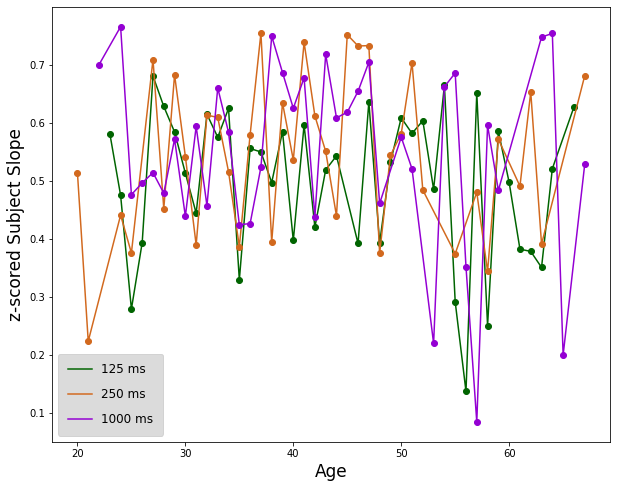

In [665]:
plt.figure(figsize = ([10, 8]))
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("z-scored Subject Slope", fontsize = 17)


slope_125, intercept_125, r_value_125, p_value_125, std_err_125 = stats.linregress(df_age_125_mean.index, df_age_125_mean['zs_slope'])
# plt.plot(df_age_125_mean.index, df_age_125_mean['zs_slope'], label = '125 ms: m = ' + str(round(slope_125, 4)), color = "darkgreen")
plt.plot(df_age_125_mean.index, df_age_125_mean['zs_slope'], label = '125 ms', color = "darkgreen")


plt.plot(df_age_125_mean['zs_slope'], 'o', color = "darkgreen")

print(r_value_125 **2)

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(df_age_250_mean.index, df_age_250_mean['zs_slope'])
# plt.plot(df_age_250_mean.index, df_age_250_mean['zs_slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "chocolate")
plt.plot(df_age_250_mean.index, df_age_250_mean['zs_slope'], label = '250 ms', color = "chocolate")


plt.plot(df_age_250_mean['zs_slope'], 'o', color = "chocolate")

print(r_value_250 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(df_age_1000_mean.index, df_age_1000_mean['zs_slope'])
# plt.plot(df_age_1000_mean.index, df_age_1000_mean['zs_slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "darkviolet")
plt.plot(df_age_1000_mean.index, df_age_1000_mean['zs_slope'], label = '1000 ms', color = "darkviolet")


plt.plot(df_age_1000_mean['zs_slope'], 'o', color = "darkviolet")

print(r_value_1000 **2)


# plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

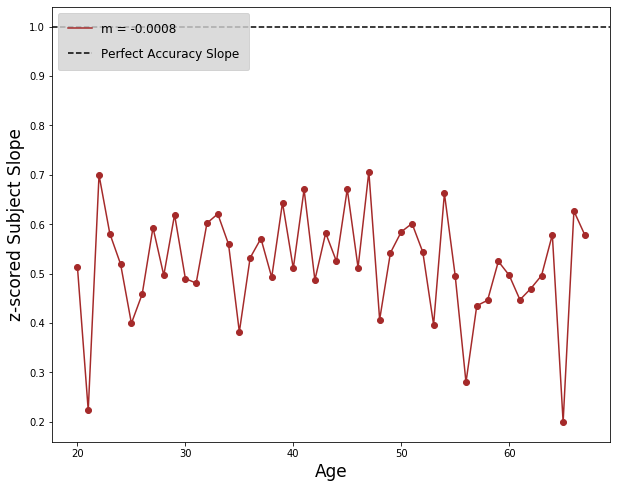

In [666]:
plt.figure(figsize = ([10, 8]))
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("z-scored Subject Slope", fontsize = 17)


slope, intercept, r_value, p_value, std_err = stats.linregress(df_age_mean.index, df_age_mean['zs_slope'])
plt.plot(df_age_mean.index, df_age_mean['zs_slope'], label = 'm = ' + str(round(slope, 4)), color = "brown")
# plt.plot(df_age_mean.index, df_age_mean['zs_slope'], color = "brown")


plt.plot(df_age_mean['zs_slope'], 'o', color = "brown")


plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

3.837543234410283e-05
0.015489740299121582
0.00834009816762638


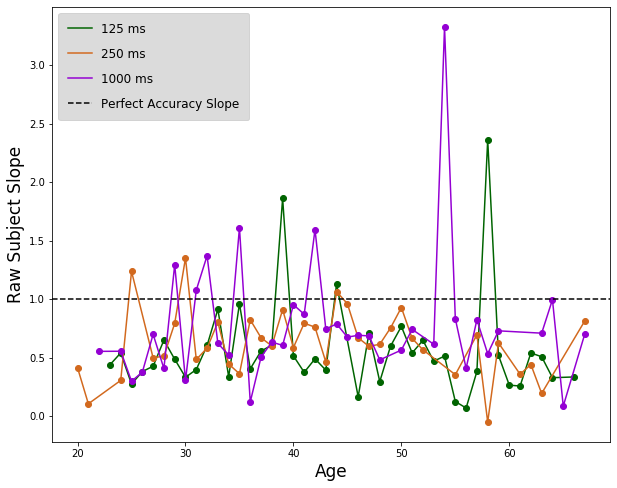

In [668]:
plt.figure(figsize = ([10, 8]))
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Raw Subject Slope", fontsize = 17)


slope_125, intercept_125, r_value_125, p_value_125, std_err_125 = stats.linregress(df_age_125_mean.index, df_age_125_mean['raw_slope'])
# plt.plot(df_age_125_mean.index, df_age_125_mean['raw_slope'], label = '125 ms: m = ' + str(round(slope_125, 4)), color = "darkgreen")
plt.plot(df_age_125_mean.index, df_age_125_mean['raw_slope'], label = '125 ms', color = "darkgreen")


plt.plot(df_age_125_mean['raw_slope'], 'o', color = "darkgreen")

print(r_value_125 **2)

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(df_age_250_mean.index, df_age_250_mean['raw_slope'])
# plt.plot(df_age_250_mean.index, df_age_250_mean['raw_slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "chocolate")
plt.plot(df_age_250_mean.index, df_age_250_mean['raw_slope'], label = '250 ms', color = "chocolate")


plt.plot(df_age_250_mean['raw_slope'], 'o', color = "chocolate")

print(r_value_250 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(df_age_1000_mean.index, df_age_1000_mean['raw_slope'])
# plt.plot(df_age_1000_mean.index, df_age_1000_mean['raw_slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "darkviolet")
plt.plot(df_age_1000_mean.index, df_age_1000_mean['raw_slope'], label = '1000 ms', color = "darkviolet")


plt.plot(df_age_1000_mean['raw_slope'], 'o', color = "darkviolet")

print(r_value_1000 **2)


plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

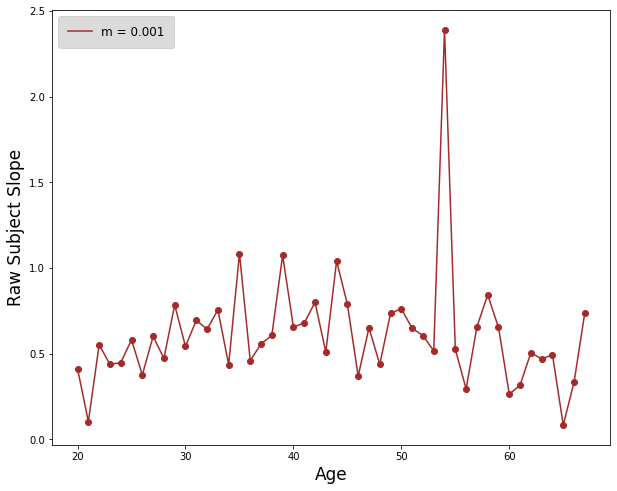

In [670]:
plt.figure(figsize = ([10, 8]))
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Raw Subject Slope", fontsize = 17)


slope, intercept, r_value, p_value, std_err = stats.linregress(df_age_mean.index, df_age_mean['raw_slope'])
plt.plot(df_age_mean.index, df_age_mean['raw_slope'], label = 'm = ' + str(round(slope, 4)), color = "brown")
# plt.plot(df_age_mean.index, df_age_mean['raw_slope'], color = "brown")


plt.plot(df_age_mean['raw_slope'], 'o', color = "brown")


# plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

## Gender

In [671]:
final_data.gender.unique()
gender_dict_count = {}
for response in final_data.gender.unique():
    gender_dict_count[response] = 0

In [672]:
for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    gender_dict_count[subj_gender] += 1
    

In [527]:
enough_samples_genders = ['Man', 'Woman']

In [674]:
gender_dict_count

# since there is not enough data in the gender conditions outside of 'Man' and 'Woman', we will not analyze that data in the gender analysis 

{'Man': 260,
 'Woman': 196,
 'Non-binary': 2,
 'trangender woman': 1,
 'Prefer not to answer': 1}

In [675]:
# data source
# subject_summary = subjectData(zscored_data)

subjID = []
gender = []
duration_cond = []
zs_slope = []
raw_slope = []

for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    if subj_gender in enough_samples_genders:
        subj_zs_slope = subject_summary.loc[subject_summary["subjID"]==subj].slope.unique()[0]
        subj_raw_slope = raw_subject_summary.loc[raw_subject_summary["subjID"]==subj].slope.unique()[0]
        subj_duration_cond = final_data.loc[final_data['subjID']==subj].duration.unique()[0]

        subjID.append(subj) 
        gender.append(subj_gender)
        duration_cond.append(subj_duration_cond)
        zs_slope.append(subj_zs_slope)
        raw_slope.append(subj_raw_slope)
#         print(subj, subj_gender, subj_duration_cond, subj_zs_slope, subj_raw_slope)

In [676]:
# Calling DataFrame constructor after zipping both lists, with columns specified
df_gender_analysis = pd.DataFrame(list(zip(subjID, gender, duration_cond, zs_slope, raw_slope)),
               columns =['subjID', 'gender', 'duration', 'zs_slope', 'raw_slope'])

In [677]:
df_gender_analysis

,subjID,gender,duration,zs_slope,raw_slope
0,541423,Man,125,0.741418,0.863528
1,104257,Woman,125,0.581617,0.314636
2,928935,Man,1000,0.558336,0.293113
3,480789,Woman,1000,0.275887,0.037957
4,442049,Man,250,0.738378,0.966599
...,...,...,...,...,...
451,352815,Man,1000,0.748482,0.651701
452,394603,Man,1000,0.685278,0.803610
453,757697,Woman,1000,0.497181,0.275333
454,508587,Man,125,0.617442,0.356431


In [678]:
df_gender_analysis.to_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/gender_slopes.csv')

In [681]:
df_gender_125 = df_gender_analysis.loc[df_gender_analysis['duration']==125]
df_gender_250 = df_gender_analysis.loc[df_gender_analysis['duration']==250]
df_gender_1000 = df_gender_analysis.loc[df_gender_analysis['duration']==1000]

In [682]:
df_gender_125_mean = df_gender_125.groupby(['gender']).mean()
df_gender_250_mean = df_gender_250.groupby(['gender']).mean()
df_gender_1000_mean = df_gender_1000.groupby(['gender']).mean()


df_gender_125_sem = df_gender_125.groupby(['gender']).sem()
df_gender_250_sem = df_gender_250.groupby(['gender']).sem()
df_gender_1000_sem = df_gender_1000.groupby(['gender']).sem()

In [683]:
df_gender_125_mean['zs_slope'], df_gender_125_sem['zs_slope']

(gender
 Man      0.518563
 Woman    0.454806
 Name: zs_slope, dtype: float64, gender
 Man      0.021591
 Woman    0.024756
 Name: zs_slope, dtype: float64)

In [684]:
df_gender_mean = df_gender_analysis.groupby(['gender']).mean()

df_gender_mean_sem = df_gender_analysis.groupby(['gender']).sem()


<!-- 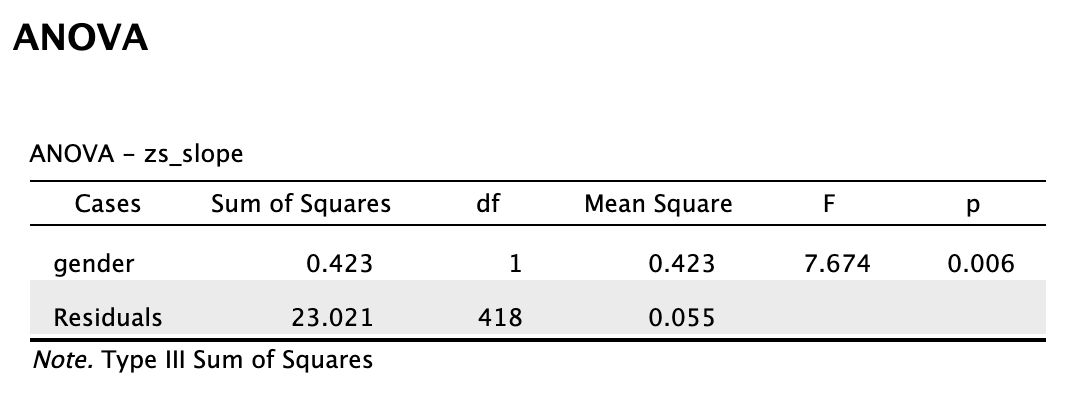 -->

In [689]:
man_125_zs = list(df_gender_125.loc[df_gender_125['gender']=='Man']['zs_slope'])
woman_125_zs = list(df_gender_125.loc[df_gender_125['gender']=='Woman']['zs_slope'])

man_250_zs = list(df_gender_250.loc[df_gender_250['gender']=='Man']['zs_slope'])
woman_250_zs = list(df_gender_250.loc[df_gender_250['gender']=='Woman']['zs_slope'])

man_1000_zs = list(df_gender_1000.loc[df_gender_1000['gender']=='Man']['zs_slope'])
woman_1000_zs = list(df_gender_1000.loc[df_gender_1000['gender']=='Woman']['zs_slope'])


all_men_slopes = man_125_zs + man_250_zs + man_1000_zs

all_women_slopes = woman_125_zs + woman_250_zs + woman_1000_zs

In [701]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_men_slopes, all_women_slopes)
print('Men Slopes vs Women Slopes')
print(fvalue, pvalue)

print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_125_zs, woman_125_zs)
print('125 ms: Men vs Women')
print(fvalue, pvalue)
print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_250_zs, woman_250_zs)
print('250 ms: Men vs Women')
print(fvalue, pvalue)
print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_1000_zs, woman_1000_zs)
print('1000 ms: Men vs Women')
print(fvalue, pvalue)


Men Slopes vs Women Slopes
10.027786386905795 0.0016458440589741795

125 ms: Men vs Women
3.794622403073592 0.053322649714988256

250 ms: Men vs Women
3.2559961610756885 0.07316886709236968

1000 ms: Men vs Women
3.0026492026274227 0.08514342760145549


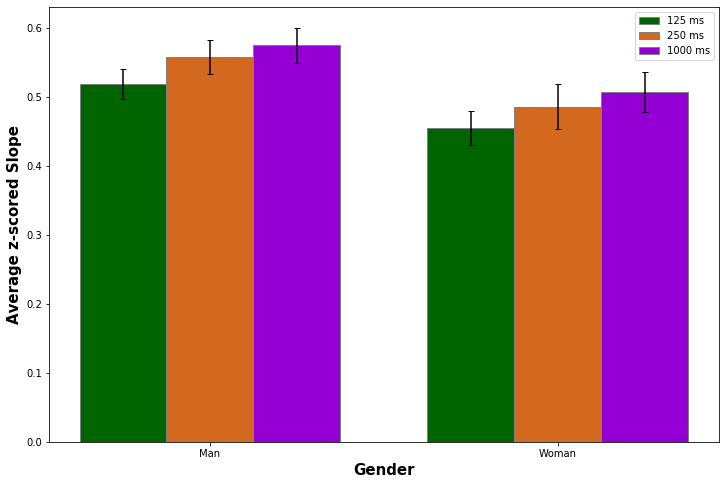

In [695]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
ms125 = df_gender_125_mean['zs_slope']
ms250 = df_gender_250_mean['zs_slope']
ms1000 = df_gender_1000_mean['zs_slope']
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='125 ms', yerr=df_gender_125_sem['zs_slope'], capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,
        edgecolor ='grey', label ='250 ms', yerr=df_gender_250_sem['zs_slope'], capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,
        edgecolor ='grey', label ='1000 ms', yerr=df_gender_1000_sem['zs_slope'], capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Average z-scored Slope', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'])
 
plt.legend()
plt.show()

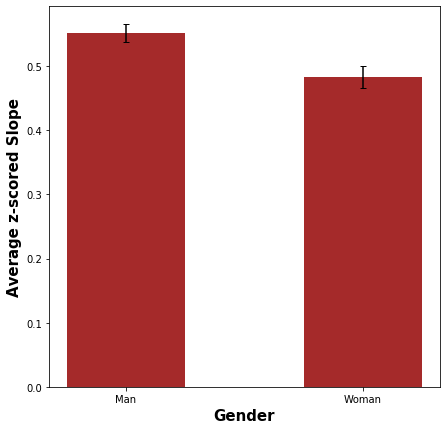

In [702]:
# Figure Size
fig = plt.figure(figsize =(7, 7))
barWidth = 0.5

 
# Horizontal Bar Plot
plt.bar(['Man', 'Woman'], df_gender_mean['zs_slope'], color='brown', yerr = df_gender_mean_sem['zs_slope'], capsize=3, width=barWidth)

plt.xticks(['Man', 'Woman'])
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Average z-scored Slope', fontweight ='bold', fontsize = 15)
 
# Show Plot
plt.show()

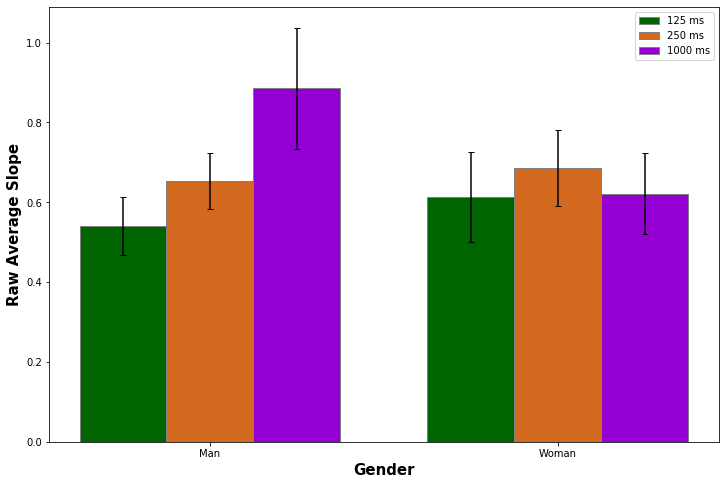

In [704]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
ms125 = df_gender_125_mean['raw_slope']
ms250 = df_gender_250_mean['raw_slope']
ms1000 = df_gender_1000_mean['raw_slope']
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='125 ms', yerr=df_gender_125_sem['raw_slope'], capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,
        edgecolor ='grey', label ='250 ms', yerr=df_gender_250_sem['raw_slope'], capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,
        edgecolor ='grey', label ='1000 ms', yerr=df_gender_1000_sem['raw_slope'], capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Raw Average Slope', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'])
 
plt.legend()
plt.show()

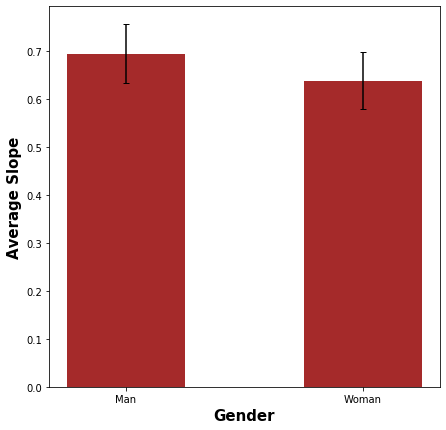

In [705]:
# Figure Size
fig = plt.figure(figsize =(7, 7))
barWidth = 0.5

 
# Horizontal Bar Plot
plt.bar(['Man', 'Woman'], df_gender_mean['raw_slope'], color='brown', yerr = df_gender_mean_sem['raw_slope'], capsize=3, width=barWidth)

plt.xticks(['Man', 'Woman'])
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Slope', fontweight ='bold', fontsize = 15)
 
# Show Plot
plt.show()

### Plots for Discrimination Figure

In [542]:
p_stim0 = 'depth_duration_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png'


p_stim1 = 'depth_duration_stimuli/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0-target.png'

In [543]:
# z_final_x_250 = z_trial_plot_data[0][1]
# z_final_y_250 = z_trial_plot_data[1][1]
# z_ste_250 = z_trial_plot_data[2][1]
# z_stim_250 = z_trial_plot_data[3][1]
# z_std_250 = z_trial_plot_data[4][1]
# z_RT_250 = z_trial_plot_data[5][1]

In [544]:
z_final_x_250.index(p_stim0), z_final_x_250.index(p_stim1)

(37, 62)

In [602]:
dist_stim0 = zs_final_data_250.loc[zs_final_data_250['stimulus'] == p_stim0]['depth_estimate']

dist_stim1 = zs_final_data_250.loc[zs_final_data_250['stimulus'] == p_stim1]['depth_estimate']



In [603]:
avg_stim0 = z_final_y_250[z_final_x_250.index(p_stim0)]

avg_stim1 = z_final_y_250[z_final_x_250.index(p_stim1)]

In [604]:
print(avg_stim0 -  avg_stim1)

-1.0317643362889932


Text(0, 0.5, 'Count')

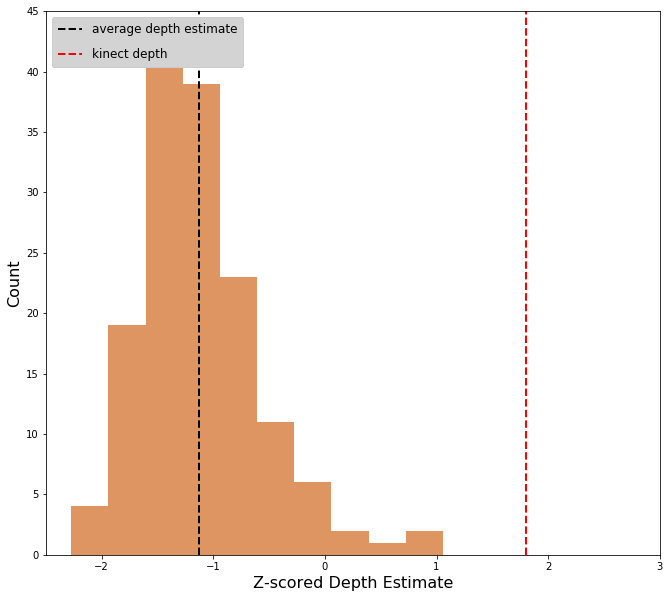

In [605]:
plt.figure(figsize=[11,10])
plt.hist(dist_stim0, color='chocolate', alpha=0.7)
plt.xlabel('Z-scored Depth Estimate', fontsize=16)

plt.xlim([-2.5,3])

plt.ylim([0,45])

# single vline with full ymin and ymax
xs = np.linspace(1, 21, 200)
plt.vlines(x=avg_stim0, ymin=0, ymax=len(xs), colors='black', ls='--', lw=2, label='average depth estimate')
plt.vlines(x=1.8, ymin=0, ymax=len(xs), colors='red', ls='--', lw=2, label='kinect depth')

legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.5, labelspacing = 1, facecolor='lightgray', framealpha=1)


plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Count')

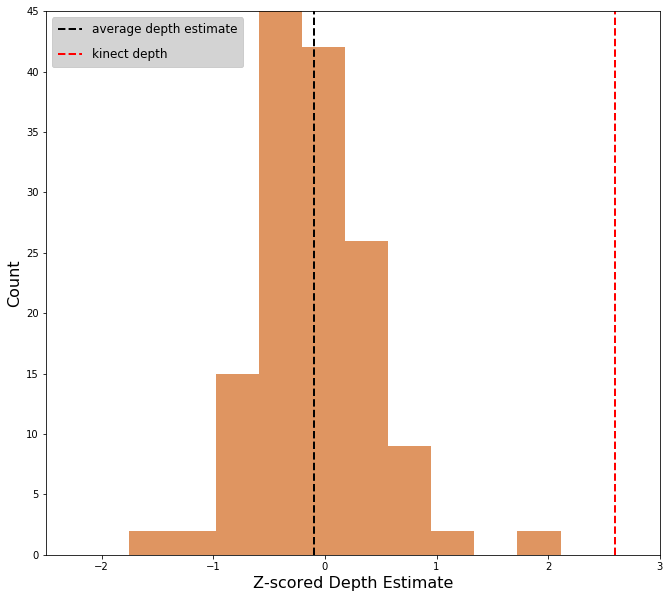

In [606]:
plt.figure(figsize=[11,10])
plt.hist(dist_stim1, color='chocolate', alpha=0.7)
plt.xlabel('Z-scored Depth Estimate', fontsize=16)

plt.xlim([-2.5,3])
plt.ylim([0,45])

# single vline with full ymin and ymax
xs = np.linspace(1, 21, 200)
plt.vlines(x=avg_stim1, ymin=0, ymax=len(xs), colors='black', ls='--', lw=2, label='average depth estimate')
plt.vlines(x=2.6, ymin=0, ymax=len(xs), colors='red', ls='--', lw=2, label='kinect depth')

legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.5, labelspacing = 1, facecolor='lightgray', framealpha=1)


plt.ylabel('Count', fontsize=16)